# #GDriveHack

Authors: Daniel Howard, Friedrich Knuth

### Reading files directly off Google Drive 

Typical share URL looks like this: 

`https://drive.google.com/file/d/FILE_ID/edit?usp=sharing`

Direct download link equivalent: 

`https://drive.google.com/uc?export=download&id=FILE_ID`

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

### Create local webserver and auto handles authentication.

Note: This requires an authentication file `client_secrets.json` which contains credentials we created from Google's Developer Console [https://console.cloud.google.com/](https://console.cloud.google.com/) necessary for accessing Google Drive's API (as well as other APIs).

#### Important security note
As a developer, you should be mindful of how you share your keys, i.e. `client_secrets.json`, and if they are accessible in your source. Typically, you should store the keys in a folder above your project as would be uploaded to open source repositories or explicitly included in your `.gitignore` file. Otherwise, your key can be taken by someone else and used to abuse access to Google's servers. Depending on the key you create, you are limited to a finite quota of Google Drive queries per key in order to prevent bandwidth abuse on Google's servers.

In [2]:
# TODO: Find way to authenticate anonymously
gauth = GoogleAuth()
## Requires client_secrets.json file with Google Drive API credentials in the same working directory of this notebook
gauth.LocalWebserverAuth()
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=307813950907-rvk9tbblercr3aklfvdrnng4uiddu715.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


Now that we have authenticated, the pyDrive library object `drive` we created by calling `GoogleDrive(auth)` can now access all the files and metadata in a Google Drive folder, including the file unique `id` and `webContentLink` strings.

In [3]:
publicFolder = '0B5c3UTO8DDZwLVlDQnBoVC12TXM'

# Get all file metadata objects referenced under the public Google Drive folder at the ID previously referenced
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % publicFolder}).GetList()

fileIDs = []
fileContentLinks = []

# iterate over files in folder
for file in file_list:
    # Filter files based on the types we wish to access
    if file['title'].endswith('32m_trans.tif'):
        
        # print file name
        print(file['title'])
        print(file['id'])
        
        # append file id to list
        fileIDs.append(file['id'])
        fileContentLinks.append(file['webContentLink'])

20161025_0524_104001002469AD00_1040010024438E00-DEM_32m_trans.tif
0B5c3UTO8DDZwcENvbkNQQTJMYlE
20160211_0512_104001001854B000_10400100175C2D00-DEM_32m_trans.tif
0B5c3UTO8DDZwSlh5amFKUDZ4T1U
20150115_0456_1040010006A12900_104001000665F400-DEM_32m_trans.tif
0B5c3UTO8DDZwZGZ1TkdWSmRQWDA
20161029_0451_103001005E3EFF00_103001005E3A0D00-DEM_32m_trans.tif
0B5c3UTO8DDZwSnp5Rk9XWG1pQ28
20160422_0501_103001005444C600_103001005401B300-DEM_32m_trans.tif
0B5c3UTO8DDZwQkVGQnVCdTdKcVk
20150607_0458_1030010043A29500_10300100436B1D00-DEM_32m_trans.tif
0B5c3UTO8DDZwQzJ6TFl5Rm9MTGM
20150527_0504_1030010043122E00_1030010040B19300-DEM_32m_trans.tif
0B5c3UTO8DDZwSTg3Q1hxbDh6ZEE
20140311_0520_103001002E546F00_103001002C956F00-DEM_32m_trans.tif
0B5c3UTO8DDZwUFZuUGtSbDlvOGs
20151002_0651_10200100457F0C00_1020010042C0CE00-DEM_32m_trans.tif
0B5c3UTO8DDZwR2NHYUM3M0U0VjQ
20150607_0609_10200100407B0400_102001003DCB1C00-DEM_32m_trans.tif
0B5c3UTO8DDZwNVlJV2FNN2JMM2s
20150204_0555_102001003A5B7900_1020010039598B00-DE

### Import GDAL and parse URLs for loading into GDAL

In [4]:
from osgeo import gdal, osr
import matplotlib.pyplot as plt

In [5]:
download_base_url = 'https://drive.google.com/uc?export=download&id='
file_blob_id = fileIDs[0]

url = download_base_url + file_blob_id

You may construct a direct url from the file blob ID like in the code block above (which allows other parameters to be set in Google URL call)  
or  
take the links provided directly from the metadata key `webContentLink` which were stored in `fileContentLinks`.

### Use GDAL to load an example `.tif` file
Note: Access to the `.tif` files in our Google Drive is mediated by url links. Any library or Python method needing access to these files must be able to reference and stream data from a URL link, which `gdal` can handle. Otherwsie, more sophisticated libraries, like `urllib`, will be needed to access the files via other means or or to download files as they are needed as temp files.

In [6]:
# url = fileContentLinks[0]

ds = gdal.Open(url)
data = ds.ReadAsArray()
gt = ds.GetGeoTransform()
proj = ds.GetProjection()
inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print(inproj)

PROJCS["WGS 84 / UTM zone 45N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32645"]]


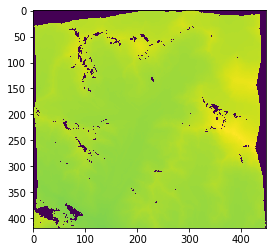

In [7]:
plt.imshow(data)